<a href="https://colab.research.google.com/github/PranavSingla122/ECG-Based-Cardiovascular-Disease-Detection/blob/main/ecg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Define dataset path
data_dir = "/content/drive/MyDrive/ecg"  # Change this to your dataset path

# Define transformations with stronger data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for CNN models
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel (if needed for pre-trained models)
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random shifts
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize between [-1,1]
])

# Load dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split dataset into training (70%), validation (15%), and testing (15%)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Print dataset details
print(f"Total images: {len(full_dataset)}")
print(f"Training images: {len(train_dataset)}, Validation images: {len(val_dataset)}, Testing images: {len(test_dataset)}")
print(f"Classes: {full_dataset.classes}")


Total images: 928
Training images: 649, Validation images: 139, Testing images: 140
Classes: ['ECG Images of Myocardial Infarction Patients (240x12=2880)', 'ECG Images of Patient that have History of MI (172x12=2064)', 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)', 'Normal Person ECG Images (284x12=3408)']


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10, Train Loss: 1.1032, Train Acc: 0.5223, Val Loss: 1.0679, Val Acc: 0.5396
Epoch 2/10, Train Loss: 0.6422, Train Acc: 0.7519, Val Loss: 0.6145, Val Acc: 0.7554
Epoch 3/10, Train Loss: 0.4252, Train Acc: 0.8413, Val Loss: 0.2392, Val Acc: 0.9209
Epoch 4/10, Train Loss: 0.2984, Train Acc: 0.9091, Val Loss: 0.2036, Val Acc: 0.9209
Epoch 5/10, Train Loss: 0.3270, Train Acc: 0.8783, Val Loss: 0.1898, Val Acc: 0.9353
Epoch 6/10, Train Loss: 0.2913, Train Acc: 0.9076, Val Loss: 0.2228, Val Acc: 0.9065
Epoch 7/10, Train Loss: 0.2238, Train Acc: 0.9245, Val Loss: 0.1596, Val Acc: 0.9496
Epoch 8/10, Train Loss: 0.1910, Train Acc: 0.9353, Val Loss: 0.1929, Val Acc: 0.9281
Epoch 9/10, Train Loss: 0.1870, Train Acc: 0.9368, Val Loss: 0.2693, Val Acc: 0.9209
Epoch 10/10, Train Loss: 0.1705, Train Acc: 0.9461, Val Loss: 0.1116, Val Acc: 0.9496


<ipython-input-15-200e29166c45>:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))  # Load best model


Test Loss: 0.0585, Test Accuracy: 0.9857


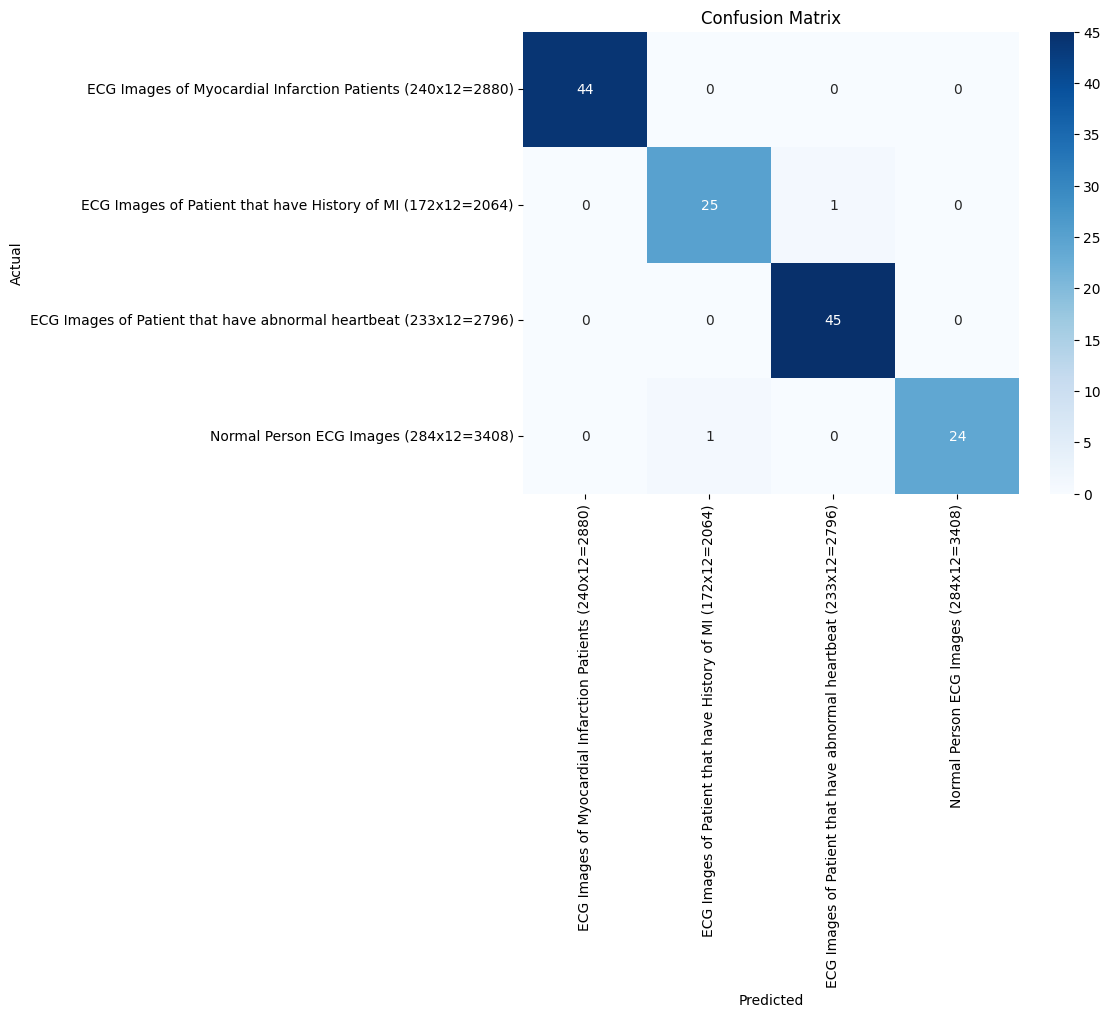

                                                                  precision    recall  f1-score   support

      ECG Images of Myocardial Infarction Patients (240x12=2880)       1.00      1.00      1.00        44
     ECG Images of Patient that have History of MI (172x12=2064)       0.96      0.96      0.96        26
ECG Images of Patient that have abnormal heartbeat (233x12=2796)       0.98      1.00      0.99        45
                          Normal Person ECG Images (284x12=3408)       1.00      0.96      0.98        25

                                                        accuracy                           0.99       140
                                                       macro avg       0.98      0.98      0.98       140
                                                    weighted avg       0.99      0.99      0.99       140



In [ ]:

# Create DataLoaders
batch_size = 32  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load Pretrained Model (ResNet50)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

# Modify the last layer for 4-class classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)  # 4 output classes
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)

# Early stopping parameters
early_stop_patience = 5
best_val_loss = float('inf')
early_stop_counter = 0

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    val_loss /= len(val_loader)
    val_acc = correct / total
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model.pth")  # Save best model
    else:
        early_stop_counter += 1

    if early_stop_counter >= early_stop_patience:
        print("Early stopping triggered!")
        break

# Test loop
def evaluate_test_set(model, test_loader):
    model.load_state_dict(torch.load("best_model.pth"))  # Load best model
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    test_loss /= len(test_loader)
    test_acc = correct / total
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification report
    print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

evaluate_test_set(model, test_loader)


